## Objetivo específico do trabalho: analisar a base construída com dados de jogos esportivos ao vivo e prever um evento específico e isolado por meio de automl e redes neurais com bons resultados

# Load and imports

In [49]:
import pandas as pd

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df05ht = pd.read_csv('data_live_scores_full.csv', encoding='utf-8')
print(df05ht.shape)

(1202399, 37)


In [50]:
df05ht.columns

Index(['date', 'minute', 'homeTeam', 'awayTeam', 'goalHome', 'goalAway',
       'shotsHome', 'shotsAway', 'crossesHome', 'crossesAway', 'assistsHome',
       'assistsAway', 'blockedShotsHome', 'blockedShotsAway', 'league',
       'corners_home', 'corners_away', 'redcards_home', 'redcards_away',
       'shotsOffgoal_home', 'shotsOffgoal_away', 'shotsOngoal_home',
       'shotsOngoal_away', 'yellowcards_home', 'yellowcards_away',
       'passes_home', 'passes_away', 'fouls_c_home', 'fouls_c_away',
       'fouls_won_home', 'fouls_won_away', 'offsides_home', 'offsides_away',
       'tackles_home', 'tackles_away', 'result', 'match_id'],
      dtype='object')

In [51]:
df05ht

,date,minute,homeTeam,awayTeam,goalHome,goalAway,shotsHome,shotsAway,crossesHome,crossesAway,...,fouls_c_home,fouls_c_away,fouls_won_home,fouls_won_away,offsides_home,offsides_away,tackles_home,tackles_away,result,match_id
0,2020-01-09,90+4:21,FC Barcelona,Club Atlético de Madrid,2.0,3.0,16.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,13.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
1,2020-01-09,90+3:42,FC Barcelona,Club Atlético de Madrid,2.0,3.0,16.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,13.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
2,2020-01-09,90+3:02,FC Barcelona,Club Atlético de Madrid,2.0,3.0,16.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,13.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
3,2020-01-09,90+2:23,FC Barcelona,Club Atlético de Madrid,2.0,3.0,15.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,13.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
4,2020-01-09,90+1:44,FC Barcelona,Club Atlético de Madrid,2.0,3.0,15.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,12.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202394,2023-12-22,2:53,Manchester City FC,Fluminense FC,1.0,0.0,2.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0,2023-12-22-Manchester City FC-Fluminense FC
1202395,2023-12-22,2:14,Manchester City FC,Fluminense FC,1.0,0.0,2.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0,2023-12-22-Manchester City FC-Fluminense FC
1202396,2023-12-22,1:36,Manchester City FC,Fluminense FC,1.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,2023-12-22-Manchester City FC-Fluminense FC
1202397,2023-12-22,0:57,Manchester City FC,Fluminense FC,1.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,2023-12-22-Manchester City FC-Fluminense FC


In [52]:
date_object = pd.to_datetime(df05ht['date'], format='%Y-%m-%d')

min_date = date_object.min()
max_date = date_object.max()

print("Os dados vão de {} até {}".format(min_date, max_date))

Os dados vão de 2020-01-08 00:00:00 até 2023-12-27 00:00:00


# Analisando e tratando os dados

## Limpeza

In [53]:
df = df05ht.copy()
print(f'Dimensão do DataFrame antes remoção: {df05ht.shape}')
print(f'Valores únicos de minutos antes da conversão: {df05ht.minute.unique()} \n')
registros_duplicados = len(df05ht[df05ht.duplicated()])
print(f'Registros duplicados: {registros_duplicados}')
df.drop_duplicates(keep='last', inplace=True)

registros_nulos = df.isnull().sum().sum()
print(f'Registros nulos: {registros_nulos}\n')
df.dropna(inplace=True)

# Convertendo os minutos para inteiros
df['minute_converted'] = df05ht['minute'].str.extract('(\d+)').astype(int)

# Removendo os minutos iguais a 0
df = df[df['minute_converted'] != 0]

# removendo partidas que aconteceram gols antes dos 10 minutos
# df_antes_15 = df[df['minute_converted'] <= 10]
# partidas_ids = df_antes_15[df_antes_15['goalHome'] + df_antes_15['goalAway'] != 0]['match_id'].unique()
# df = df[~df['match_id'].isin(partidas_ids)]

# removendo minutos > 45
# df = df[(df['minute_converted'] >= 1) & (df['minute_converted'] <= 45)]

df['minute'] = df['minute_converted']
df.drop(columns=['minute_converted'], inplace=True)
# print(f'Jogos que serão retirados: {len(invalid_ids)}\n')

print(f'Dimensão do DataFrame após remoção: {df.shape}')
print(f'Total de registros retirados: {df05ht.shape[0] - df.shape[0]}')

Dimensão do DataFrame antes remoção: (1202399, 37)
Valores únicos de minutos antes da conversão: ['90+4:21' '90+3:42' '90+3:02' ... '5:30' '44:46' '24:25'] 

Registros duplicados: 70
Registros nulos: 41295

Dimensão do DataFrame após remoção: (1190560, 37)
Total de registros retirados: 11839


In [54]:
df_ht = df.copy()

In [55]:
# df = df_copy.copy()

# janela_tempo = 10
# df.sort_values(by=['match_id', 'minute'], inplace=True) # ordenando por match_id e minuto

# # definindo janela de tempo após acontecimento do evento (gol casa ou fora)
# df_not_goal = df[(df['goalHome'] == 0) & (df['goalAway'] == 0)] # dataframe sem gol
# df_goal = df[df['goalHome'] + df['goalAway'] != 0] # dataframe com a ocorrencia do evento (gol)

# df = pd.concat([df_not_goal, df_goal], axis=0)

In [56]:
# ordenar por data
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.sort_values(by=['date', 'minute'], inplace=True)

In [57]:
def identificar_eventos_gol(df, janela_tempo=10):
    df.sort_values(by=['match_id', 'minute', 'goalHome', 'goalAway'], inplace=True, ascending=True)
    df.drop_duplicates(subset=['match_id', 'minute'], keep='last', inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Calculando a diferença no número de gols
    df['dif_gol_casa'] = df['goalHome'].diff().fillna(0)
    df['dif_gol_fora'] = df['goalAway'].diff().fillna(0)

    # Identificando minutos dos gols
    df['gol'] = df['dif_gol_casa'].gt(0) | df['dif_gol_fora'].gt(0)
    # Função para marcar a janela de tempo em torno de cada gol
    def marcar_janela(gol_df):
        gol_df['result'] = 0
        minutos_gol = gol_df[gol_df['gol']]['minute']
        for minuto in minutos_gol:
            gol_df.loc[(gol_df['minute'] >= minuto - janela_tempo) & (gol_df['minute'] < minuto), 'result'] = 1
        return gol_df

    df = df.groupby('match_id').apply(marcar_janela)

    df.drop(columns=['dif_gol_casa', 'dif_gol_fora', 'gol'], inplace=True)
    return df

# Uso da função
df = df_ht.copy()
df = identificar_eventos_gol(df)


In [58]:
# # Iterar sobre cada match_id único.
# # Para cada partida, identificar o primeiro gol (se houver).
# # Registrar o gols e, após encontrar o gol, marcar os 10 registros anteriores.

# df = df_ht.copy()

# # Configurações iniciais
# janela_tempo = 10
# # Ordenando o DataFrame por 'match_id' e 'minute'
# df.sort_values(by=['match_id', 'minute', 'goalHome', 'goalAway'], inplace=True, ascending=True)
# df.drop_duplicates(subset=['match_id', 'minute'], keep='last', inplace=True)
# df.reset_index(drop=True, inplace=True)

# # Função para identificar os últimos 10 registros antes do primeiro gol em cada partida
# def marcar_ultimos_10_antes_do_gol(df):
#     # Identificando o índice do primeiro gol
#     primeiro_gol_idx = df[(df['goalHome'] > 0) | (df['goalAway'] > 0)].index.min()
#     # Verificando se existe um gol na partida
#     if pd.notna(primeiro_gol_idx):
#         # Calculando o índice inicial para marcar os 10 registros anteriores
#         inicio_intervalo = max(primeiro_gol_idx - 10, 0)
#         # Marcando os registros
#         df.loc[inicio_intervalo:primeiro_gol_idx, 'result'] = 1
#         # Retirando o resto dos registros
#         df = df.loc[:primeiro_gol_idx]
#     return df

# # Aplicando a função a cada grupo de partida
# df = df.groupby('match_id').apply(marcar_ultimos_10_antes_do_gol)


In [59]:
df_trated = df.copy()

In [60]:
df[df['goalHome'] + df['goalAway'] != 0]['match_id'].unique() # partidas com gols

array(['2020-01-08-Valencia CF-Real Madrid CF',
       '2020-01-09-FC Barcelona-Club Atlético de Madrid',
       '2020-01-21-Carabobo FC-Club Universitario de Deportes', ...,
       '2023-12-24-Wolverhampton Wanderers FC-Chelsea FC',
       '2023-12-27-Brentford FC-Wolverhampton Wanderers FC',
       '2023-12-27-Chelsea FC-Crystal Palace FC'], dtype=object)

In [61]:
# df.to_csv('data_teste.csv', index=False, encoding='utf-8')

In [62]:
df[(df['goalHome'] == 0 ) & (df['goalAway'] == 0) & (df['minute'] == 90)]['match_id'].unique() # partidas que não tiveram gol no primeiro tempo

array(['2020-01-12-Real Madrid CF-Club Atlético de Madrid',
       '2020-01-26-SE Palmeiras-São Paulo FC',
       '2020-01-28-Al Sailiya SC-Shahr Khodro FC',
       '2020-01-30-Grêmio Novorizontino-Red Bull Bragantino',
       '2020-02-04-Club Universidad de Chile-SC Internacional',
       '2020-02-09-Grêmio Novorizontino-Ituano Futebol Clube',
       '2020-02-15-São Paulo FC-SC Corinthians Paulista',
       '2020-02-16-Associação Ferroviária de Esportes-Santos FC Sao Paulo',
       '2020-02-18-CD Unión La Calera-Fluminense FC',
       '2020-02-20-CD Oriente Petrolero-CR Vasco da Gama',
       '2020-02-20-Club Deportes Tolima SA-SC Internacional',
       '2020-02-22-Kawasaki Frontale-Sagan Tosu',
       '2020-02-26-Club Sport Huancayo-Argentinos Juniors',
       '2020-02-29-Orlando City SC-Real Salt Lake',
       '2020-02-29-Santos FC Sao Paulo-SE Palmeiras',
       '2020-03-13-Grêmio FB Porto Alegrense-SC Internacional',
       '2020-03-14-AA Internacional de Limeira-SE Palmeiras',
  

In [63]:
df[df['match_id'] == '2020-01-21-Carabobo FC-Club Universitario de Deportes'][['minute', 'goalHome', 'goalAway', 'result']] # exemplo de como ficou

minute  goalHome  \
match_id                                                                   
2020-01-21-Carabobo FC-Club Universitario de De... 270       1       0.0   
                                                   271       2       0.0   
                                                   272       3       0.0   
                                                   273       4       0.0   
                                                   274       5       0.0   
...                                                        ...       ...   
                                                   355      86       1.0   
                                                   356      87       1.0   
                                                   357      88       1.0   
                                                   358      89       1.0   
                                                   359      90       1.0   

                                                        goalAway  result  
match_id                                                                  
2020-01-21-Carabobo FC-Club Universitario de De... 270       0.0       0  
                                                   271       0.0       0  
                                                   272       0.0       0  
                                                   273       0.0       0  
                                                   274       0.0       0  
...                                                          ...     ...  
                                                   355       1.0       0  
                                                   356       1.0       0  
                                                   357       1.0       0  
                                                   358       1.0       0  
                                                   359       1.0       0  

[90 rows x 4 columns]

In [64]:
df[df['match_id'] == '2020-01-08-Valencia CF-Real Madrid CF'][['minute', 'goalHome', 'goalAway', 'result']].to_csv('data_teste.csv', index=False, encoding='utf-8')

## Seleção de Ligas, Cálculo de Posse de Bola e Limpeza do DataFrame

In [65]:
# Calculando o tempo de posse de bola
total_passes = df['passes_away'] + df['passes_home']
df['possessiontime_away'] = round((df['passes_away'] / total_passes) * 100)
df['possessiontime_home'] = round((df['passes_home'] / total_passes) * 100)

df['possessiontime_home'].fillna(method='bfill', inplace=True)
df['possessiontime_away'].fillna(method='bfill', inplace=True)

print("\nDados de posse de bola:\n", df[['possessiontime_away', 'possessiontime_home']].head())

# Renomeando colunas
new_column_names = {'fouls_won_away': 'fouls_away', 'fouls_won_home': 'fouls_home'}
df.rename(columns=new_column_names, inplace=True)
print("\nColunas renomeadas:\n", df.columns)

# Removendo colunas desnecessárias e limpando o DataFrame
columns_to_drop = ["date", 'passes_home', 'passes_away', 'fouls_c_home', 'fouls_c_away', 'crossesHome', 'crossesAway', 'assistsHome',
       'assistsAway']
df.drop(columns=columns_to_drop, inplace=True)
print("\nDataFrame após remover colunas:\n", df.columns)

df.reset_index(drop=True, inplace=True)
print(f'Dimensão do DataFrame após modificações: {df.shape}')
df.isnull().sum()


Dados de posse de bola:
                                          possessiontime_away  \
match_id                                                       
2020-01-08-Valencia CF-Real Madrid CF 0                 93.0   
                                      1                 85.0   
                                      2                 87.0   
                                      3                 86.0   
                                      4                 87.0   

                                         possessiontime_home  
match_id                                                      
2020-01-08-Valencia CF-Real Madrid CF 0                  7.0  
                                      1                 15.0  
                                      2                 13.0  
                                      3                 14.0  
                                      4                 13.0  

Colunas renomeadas:
 Index(['date', 'minute', 'homeTeam', 'awayTeam', 'goalHome', '

minute                 0
homeTeam               0
awayTeam               0
goalHome               0
goalAway               0
shotsHome              0
shotsAway              0
blockedShotsHome       0
blockedShotsAway       0
league                 0
corners_home           0
corners_away           0
redcards_home          0
redcards_away          0
shotsOffgoal_home      0
shotsOffgoal_away      0
shotsOngoal_home       0
shotsOngoal_away       0
yellowcards_home       0
yellowcards_away       0
fouls_home             0
fouls_away             0
offsides_home          0
offsides_away          0
tackles_home           0
tackles_away           0
result                 0
match_id               0
possessiontime_away    0
possessiontime_home    0
dtype: int64

## Tratando o formato das ligas para ligas existentes 

In [66]:
# Obtendo ligas únicas
leagues_opta = df['league'].unique()
print("Ligas únicas:", leagues_opta)

# Iterando através das ligas únicas
for league in leagues_opta:
    print("Liga atual:", league)

# Mapeamento de nomes de ligas
name_mapping = {
    'England - Premier League': 'England - Premier League',
    'Germany - Bundesliga': 'Germany - Bundesliga',
    'Spain - Primera División': 'Spain - La Liga',
    'France - Ligue 1': 'France - Ligue 1',
    'Italy - Serie A': 'Italy - Serie A',
    'USA - MLS': 'USA - Major League Soccer',
    'Brazil - Serie A': 'Brazil - Serie A',
    'Netherlands - Eredivisie': 'Netherlands - Eredivisie',
    'England - Championship': 'England - Championship',
    'Portugal - Primeira Liga': 'Portugal - Liga Portugal',
    'Romania - Liga I': 'Romania - Liga 1',
    "World - FIFA Women's World Cup": 'World - World Cup Women',
    'England - League One': 'England - League One',
    'England - League Two': 'England - League Two',
    'Europe - UEFA Europa Conference League': 'Europe - Europa Conference League',
    'England - League Cup': 'England - Carabao Cup',
    'Europe - UEFA Super Cup': 'Europe - Uefa Super Cup',
    'Europe - UEFA Champions League': 'Europe - Champions League',
    'Germany - DFB Pokal': 'Germany - DFB Pokal',
    'Italy - Coppa Italia': 'Italy - Coppa Italia',
    'Scotland - Premiership': 'Scotland - Premiership',
    'Germany - Super Cup': 'Germany - Super Cup',
    'South America - CONMEBOL Libertadores': 'South America - Copa Libertadores',
    'England - Community Shield': 'England - Community Shield',
    'N/C America - Concacaf Gold Cup': 'World - CONCACAF Gold Cup',
    'Europe - UEFA U21 Championship': 'Europe - Euro U21',
    'Australia - A-League Men': 'Australia - A-League',
    'Portugal - Play-offs 1/2': 'Portugal - Primeira Liga - Play-offs',
    'Europe - UEFA European Championship Qualifiers': 'Europe - Euro Qualification',
    'Germany - Play-offs 1/2': 'Germany - Bundesliga Play-offs',
    'Europe - UEFA Nations League': 'Europe - UEFA Nations League',
    'Europe - UEFA Europa League': 'Europe - Europa League',
    'England - FA Cup': 'England - FA Cup',
    'Spain - Copa del Rey': 'Spain - Copa Del Rey',
    'World - FIFA World Cup': 'World - FIFA World Cup',
    'France - Coupe de France': 'France - Coupe de France',
    'Spain - Super Cup': 'Spain - Super Cup',
    'Italy - Super Cup': 'Italy - Super Cup',
    'World - FIFA Club World Cup': 'World - FIFA Club World Cup',
    'Argentina - Liga Profesional Argentina': "Argentina - Superliga",
    'Brazil - Paulista A1': 'Brazil - Paulista A1',
    'Brazil - Copa do Brasil': 'Brazil - Copa Do Brasil',
    'Denmark - Superliga':'Denmark - Superliga',
    'Mexico - Liga MX': 'Mexico - Liga MX',
    'Greece - Super League 1': 'Greece - Super League',
    'Asia - AFC Champions League': 'Asia - AFC Champions League', 
    'South America - CONMEBOL Sudamericana': 'South America - Copa Sudamericana', 
    'Spain - Segunda División': 'Spain - La Liga 2',
    'Saudi Arabia - Saudi League': 'Saudi Arabia - Pro League',
    'Italy - Serie B': 'Italy - Serie B',
    'Japan - J1 League': 'Japan - J-League',
    'South America - CONMEBOL World Cup Qualifiers': 'World - WC Qualification South America',
    'Europe - UEFA World Cup Qualifiers': 'Europe - WC Qualification Europe', 
    "Europe - UEFA Women's Championship": "Europe - UEFA Women's EURO",
    "France - Trophée des Champions": 'France - Super Cup',
    'Brazil - Supercopa do Brasil': 'Brazil - Supercopa do Brasil',
    'South America - CONMEBOL Recopa': 'South America - Recopa Sudamericana',
    'Europe - UEFA European Championship': 'Europe - European Championship', 
    'N/C America - Leagues Cup': 'North & Central America - Leagues Cup',
    'South America - CONMEBOL Copa America': 'South America - Copa America',

}
print("\nTamanho do mapeamento de nomes de ligas:", len(name_mapping))

# Verificando o número de ligas únicas
print("Número de ligas únicas:", len(leagues_opta))
print("Número de ligas únicas após o mapeamento:", len(name_mapping))

# Atualizando os nomes das ligas no DataFrame
df['league'] = df['league'].replace(name_mapping)

# Verificando algumas linhas do DataFrame após a atualização dos nomes das ligas
# print("\nDataFrame após atualizar os nomes das ligas:\n", df['league'].unique())
for league in df['league'].unique():
    print("Liga atual no dataframe:", league)

Ligas únicas: ['Spain - Super Cup' 'South America - CONMEBOL Libertadores'
 'Asia - AFC Champions League' 'Brazil - Paulista A1'
 'South America - CONMEBOL Sudamericana' 'Brazil - Copa do Brasil'
 'Brazil - Supercopa do Brasil' 'South America - CONMEBOL Recopa'
 'Japan - J1 League' 'USA - MLS' 'Germany - Play-offs 1/2'
 'Mexico - Liga MX' 'Scotland - Premiership' 'Brazil - Serie A'
 'France - Ligue 1' 'Europe - UEFA Champions League'
 'England - Community Shield' 'England - League Cup'
 'Europe - UEFA Nations League' 'Greece - Super League 1'
 'Germany - DFB Pokal' 'Denmark - Superliga' 'England - Championship'
 'England - League One' 'England - League Two' 'England - Premier League'
 'Spain - Primera División' 'Netherlands - Eredivisie'
 'Spain - Segunda División' "Europe - UEFA Women's Championship"
 'Europe - UEFA Europa League' 'Germany - Bundesliga'
 'Portugal - Primeira Liga' 'Italy - Serie A' 'Europe - UEFA Super Cup'
 'Italy - Serie B' 'Germany - Super Cup'
 'South America - CO

## Balanceamento de Dados e Visualização da Distribuição de Resultados por Liga

Contando partidas por time...
Total de partidas: 8134

Filtrando dados de ligas...
Dados filtrados:

league
USA - Major League Soccer            48524
Brazil - Serie A                     37435
Argentina - Superliga                36538
England - Championship               34827
England - League One                 31679
England - League Two                 31230
Japan - J-League                     28336
Spain - La Liga 2                    27360
Mexico - Liga MX                     24839
Spain - La Liga                      21150
South America - Copa Libertadores    21060
Europe - Champions League            21060
Europe - Europa League               20516
England - Premier League             19530
Saudi Arabia - Pro League            19260
Asia - AFC Champions League          19080
Italy - Serie B                      18899
France - Ligue 1                     18719
Italy - Serie A                      18540
Europe - UEFA Nations League         17550
South America - Copa Sudamerican

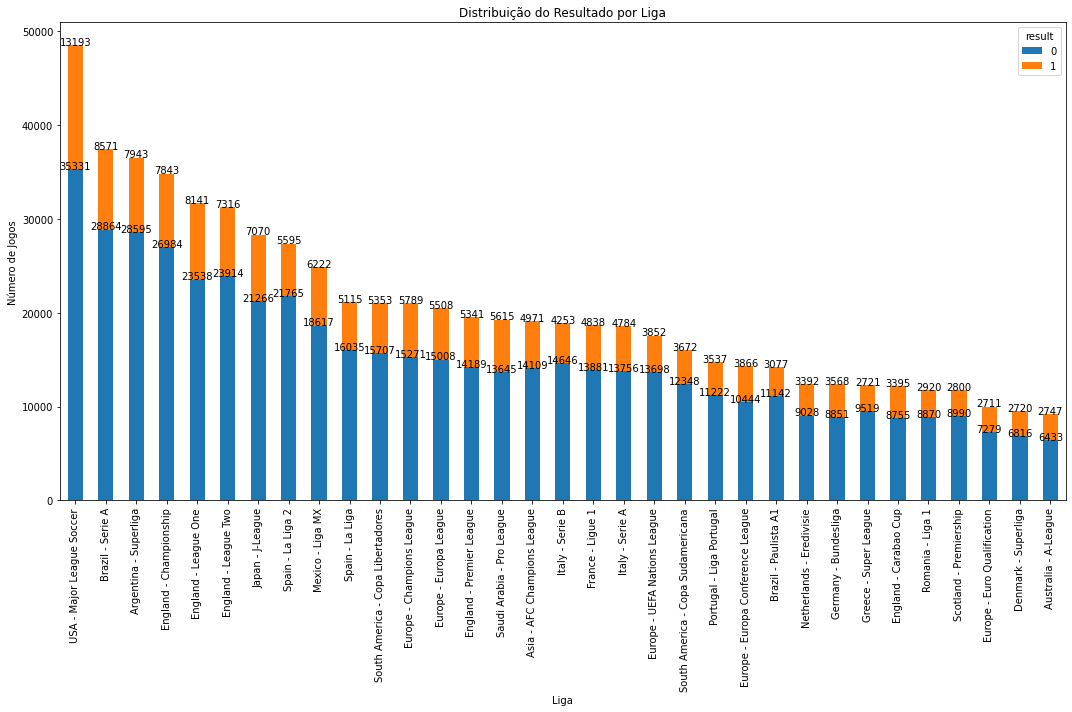

<Figure size 432x288 with 0 Axes>

In [67]:
# Função para filtrar ligas com base no número mínimo de partidas
def filter_leagues(df, league_col, matches, min_matches=100):
    # Agrupa o DataFrame por liga e conta o número único de partidas para cada liga
    league_game_counts = df.groupby(league_col)[matches].nunique()
    # Filtra para manter apenas as ligas com um número de partidas igual ou maior que min_matches
    leagues_filtered = league_game_counts[league_game_counts >= min_matches].index
    # Filtra o DataFrame original para incluir apenas linhas das ligas selecionadas
    filtered_data = df[df[league_col].isin(leagues_filtered)]
    return filtered_data

# Função para equilibrar o conjunto de dados com base na contagem de resultados em cada liga
def balance_data(df, league_col='league', result_col='result'):
    df = df.drop_duplicates()

    leagues = df[league_col].unique()
    # Lista para armazenar os DataFrames balanceados para cada liga
    balanced_dfs = []

    # Itera sobre cada liga para balancear os dados
    for league in leagues:
        # Filtra o DataFrame para incluir apenas dados da liga atual
        league_df = df[df[league_col] == league]

        # Conta o número de ocorrências de cada resultado na liga
        result_counts = league_df[result_col].value_counts()
        # Obtém o menor número de ocorrências entre os resultados
        min_count = result_counts.min()

        # Itera sobre os resultados únicos para balancear a quantidade de cada um
        for result in league_df[result_col].unique():
            # Define o tamanho da amostra com base no menor número de ocorrências
            sample_size = min(min_count, result_counts[result])
            # Coleta uma amostra aleatória de dados para o resultado atual
            sampled_df = league_df[league_df[result_col] == result].sample(sample_size, random_state=42)
            # Adiciona a amostra balanceada à lista
            balanced_dfs.append(sampled_df)

    # Combina todos os DataFrames balanceados em um único DataFrame
    balanced_data = pd.concat(balanced_dfs).reset_index(drop=True)

    return balanced_data

# def balance_data_stratified(df, league_col='league', result_col='result'):
#     df = df.drop_duplicates()

#     leagues = df[league_col].unique()
#     balanced_dfs = []

#     for league in leagues:
#         league_df = df[df[league_col] == league]

#         # Conta o número total de ocorrências na liga
#         total_count = len(league_df)
#         result_counts = league_df[result_col].value_counts()

#         for result in league_df[result_col].unique():
#             # Calcula a proporção do resultado na liga
#             result_proportion = result_counts[result] / total_count
#             # Define o tamanho da amostra com base na proporção
#             sample_size = int(result_proportion * total_count)
#             sampled_df = league_df[league_df[result_col] == result].sample(sample_size, random_state=42)
#             balanced_dfs.append(sampled_df)

#     balanced_data = pd.concat(balanced_dfs).reset_index(drop=True)
#     return balanced_data


# from imblearn.over_sampling import SMOTE

# # Função para equilibrar o conjunto de dados com SMOTE
# def balance_data_with_smote(df, league_col='league', result_col='result', features_cols=[]):
#     df = df.drop_duplicates()

#     leagues = df[league_col].unique()
#     balanced_dfs = []

#     # Cria uma instância do SMOTE
#     smote = SMOTE(random_state=42)

#     for league in leagues:
#         league_df = df[df[league_col] == league]

#         # Separa as features e o target
#         X = league_df[features_cols]  
#         y = league_df[result_col]

#         # Aplica o SMOTE
#         X_resampled, y_resampled = smote.fit_resample(X, y)

#         # Combina os recursos e o target resampled de volta em um DataFrame
#         resampled_df = pd.DataFrame(X_resampled, columns=features_cols)
#         resampled_df[result_col] = y_resampled

#         balanced_dfs.append(resampled_df)

#     balanced_data = pd.concat(balanced_dfs).reset_index(drop=True)
#     return balanced_data




print("Contando partidas por time...")
total_matches_per_team = len(df['match_id'].unique())
print("Total de partidas:", total_matches_per_team)

print("\nFiltrando dados de ligas...")
filtered_data = filter_leagues(df, 'league', 'match_id')
print("Dados filtrados:\n")
print(filtered_data['league'].value_counts())

print("\nBalanceando dados...")
# balanced_data = balance_data(filtered_data)
# leagues = filtered_data['league']
# matchs_ids = filtered_data['match_id']
# balanced_data = balance_data_with_smote(filtered_data, features_cols=df.drop(columns=['league', 'match_id', 'result', 'homeTeam', 'awayTeam']).columns)
# balanced_data['league'] = leagues
# balanced_data['match_id'] = matchs_ids

balanced_data = balance_data(filtered_data)

print("Dados balanceados:\n")
print(balanced_data['result'].value_counts())

balanced_data = filtered_data.copy()

league_distribution = balanced_data.groupby(['league', 'result']).size().unstack()
sorted_leagues = league_distribution.sum(axis=1).sort_values(ascending=False).head(100).index

print("Contando partidas depois dos filtros...")
total_matches_per_team = len(balanced_data['match_id'].unique())
print("Total de partidas:", total_matches_per_team)

plt.figure(figsize=(15, 10))
ax = league_distribution.loc[sorted_leagues].plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Distribuição do Resultado por Liga')
plt.ylabel('Número de Jogos')
plt.xlabel('Liga')
plt.tight_layout()
plt.xticks(rotation=90)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.0f}', (x + width/2, y + height), ha='center')

plt.show()
plt.clf()  

In [68]:
balanced_data

,minute,homeTeam,awayTeam,goalHome,goalAway,shotsHome,shotsAway,blockedShotsHome,blockedShotsAway,league,...,fouls_home,fouls_away,offsides_home,offsides_away,tackles_home,tackles_away,result,match_id,possessiontime_away,possessiontime_home
270,1,Carabobo FC,Club Universitario de Deportes,0.0,0.0,0.0,0.0,0.0,0.0,South America - Copa Libertadores,...,0.0,0.0,0.0,0.0,0.0,0.0,0,2020-01-21-Carabobo FC-Club Universitario de D...,40.0,60.0
271,2,Carabobo FC,Club Universitario de Deportes,0.0,0.0,0.0,1.0,0.0,1.0,South America - Copa Libertadores,...,0.0,0.0,0.0,0.0,0.0,1.0,0,2020-01-21-Carabobo FC-Club Universitario de D...,58.0,42.0
272,3,Carabobo FC,Club Universitario de Deportes,0.0,0.0,0.0,1.0,0.0,1.0,South America - Copa Libertadores,...,0.0,0.0,0.0,0.0,0.0,1.0,0,2020-01-21-Carabobo FC-Club Universitario de D...,59.0,41.0
273,4,Carabobo FC,Club Universitario de Deportes,0.0,0.0,0.0,2.0,0.0,1.0,South America - Copa Libertadores,...,0.0,0.0,0.0,0.0,0.0,1.0,0,2020-01-21-Carabobo FC-Club Universitario de D...,59.0,41.0
274,5,Carabobo FC,Club Universitario de Deportes,0.0,0.0,0.0,2.0,0.0,1.0,South America - Copa Libertadores,...,0.0,0.0,0.0,0.0,0.0,1.0,0,2020-01-21-Carabobo FC-Club Universitario de D...,61.0,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731847,41,Chelsea FC,Crystal Palace FC,1.0,0.0,5.0,4.0,1.0,2.0,England - Premier League,...,6.0,7.0,1.0,5.0,11.0,8.0,1,2023-12-27-Chelsea FC-Crystal Palace FC,39.0,61.0
731848,42,Chelsea FC,Crystal Palace FC,1.0,0.0,5.0,4.0,1.0,2.0,England - Premier League,...,6.0,7.0,1.0,5.0,11.0,8.0,1,2023-12-27-Chelsea FC-Crystal Palace FC,39.0,61.0
731849,43,Chelsea FC,Crystal Palace FC,1.0,0.0,6.0,4.0,2.0,2.0,England - Premier League,...,6.0,7.0,1.0,5.0,11.0,9.0,1,2023-12-27-Chelsea FC-Crystal Palace FC,37.0,63.0
731850,44,Chelsea FC,Crystal Palace FC,1.0,0.0,6.0,4.0,2.0,2.0,England - Premier League,...,6.0,7.0,1.0,5.0,11.0,9.0,1,2023-12-27-Chelsea FC-Crystal Palace FC,36.0,64.0


In [69]:
# Ordenando o DataFrame
df.sort_values(by=['match_id', 'minute'], inplace=True)

In [70]:
balanced_data.reset_index(drop=True, inplace=True)
balanced_data.to_csv("data_balanced.csv", index=False, encoding='utf-8')

In [71]:
balanced_data.value_counts('result')

result
0    508516
1    168439
Name: count, dtype: int64

In [72]:
balanced_data

,minute,homeTeam,awayTeam,goalHome,goalAway,shotsHome,shotsAway,blockedShotsHome,blockedShotsAway,league,...,fouls_home,fouls_away,offsides_home,offsides_away,tackles_home,tackles_away,result,match_id,possessiontime_away,possessiontime_home
0,1,Carabobo FC,Club Universitario de Deportes,0.0,0.0,0.0,0.0,0.0,0.0,South America - Copa Libertadores,...,0.0,0.0,0.0,0.0,0.0,0.0,0,2020-01-21-Carabobo FC-Club Universitario de D...,40.0,60.0
1,2,Carabobo FC,Club Universitario de Deportes,0.0,0.0,0.0,1.0,0.0,1.0,South America - Copa Libertadores,...,0.0,0.0,0.0,0.0,0.0,1.0,0,2020-01-21-Carabobo FC-Club Universitario de D...,58.0,42.0
2,3,Carabobo FC,Club Universitario de Deportes,0.0,0.0,0.0,1.0,0.0,1.0,South America - Copa Libertadores,...,0.0,0.0,0.0,0.0,0.0,1.0,0,2020-01-21-Carabobo FC-Club Universitario de D...,59.0,41.0
3,4,Carabobo FC,Club Universitario de Deportes,0.0,0.0,0.0,2.0,0.0,1.0,South America - Copa Libertadores,...,0.0,0.0,0.0,0.0,0.0,1.0,0,2020-01-21-Carabobo FC-Club Universitario de D...,59.0,41.0
4,5,Carabobo FC,Club Universitario de Deportes,0.0,0.0,0.0,2.0,0.0,1.0,South America - Copa Libertadores,...,0.0,0.0,0.0,0.0,0.0,1.0,0,2020-01-21-Carabobo FC-Club Universitario de D...,61.0,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676950,41,Chelsea FC,Crystal Palace FC,1.0,0.0,5.0,4.0,1.0,2.0,England - Premier League,...,6.0,7.0,1.0,5.0,11.0,8.0,1,2023-12-27-Chelsea FC-Crystal Palace FC,39.0,61.0
676951,42,Chelsea FC,Crystal Palace FC,1.0,0.0,5.0,4.0,1.0,2.0,England - Premier League,...,6.0,7.0,1.0,5.0,11.0,8.0,1,2023-12-27-Chelsea FC-Crystal Palace FC,39.0,61.0
676952,43,Chelsea FC,Crystal Palace FC,1.0,0.0,6.0,4.0,2.0,2.0,England - Premier League,...,6.0,7.0,1.0,5.0,11.0,9.0,1,2023-12-27-Chelsea FC-Crystal Palace FC,37.0,63.0
676953,44,Chelsea FC,Crystal Palace FC,1.0,0.0,6.0,4.0,2.0,2.0,England - Premier League,...,6.0,7.0,1.0,5.0,11.0,9.0,1,2023-12-27-Chelsea FC-Crystal Palace FC,36.0,64.0
